# **Bulk States**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import Materials_Parameters as mp
from MTI_Discretization import eigenstates_Dirichlet as eigenstates
from MTI_Second_Order import FMTI2_NeumannBC, Change_Basis, Block_Reverse

# parameters
d = 100.; mu = 0.010; Delta = 0.005
# coupling matrices
Gamma = np.matrix([[1,0],[0,1],[1,0],[0,1]])

## Finite Magnetization $\Lambda = 20$ meV

#### **Energy Spectrum**

In [2]:
# lattice
Nlat = 100; d = 100.; dZ = d/(Nlat-1)

egval = []; spinors = []
momentum = np.linspace(-0.15, 0.15, 101)

for k in momentum:

    # eigenstates
    lattice, egv, wf = eigenstates(Nlat=Nlat, dZ=dZ, kx = k, ky = 0., L = 0.020, C = 0.3)

    # indices for sorting by absolute value
    idx_sort = np.argsort(egv)
    # sort egval accordingly
    egv = egv[idx_sort]
    # sort wf accordingly
    wf = wf[idx_sort, :, :]   
    
    egval.append(egv); spinors.append(wf) 


egval = np.array(egval)
spinors = np.array(spinors)

print(egval.shape, spinors[0].shape)

(101, 400) (400, 100, 4)


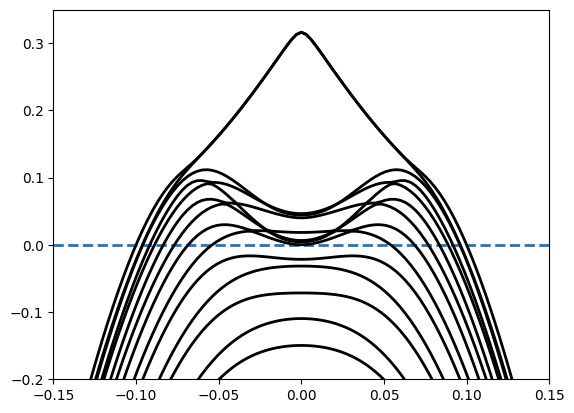

In [3]:
fig, ax = plt.subplots(1)

ax.axhline(0, ls='--', lw=2)


n = 50
for idx in range(n):

    iegv = 200 - int(n/2) + idx 
    
    ax.plot(momentum, egval[:,iegv], c='black', lw=2)


ax.set_xlim(-0.15, 0.15);
ax.set_ylim(-0.2, 0.35);

(101, 400, 100, 4)


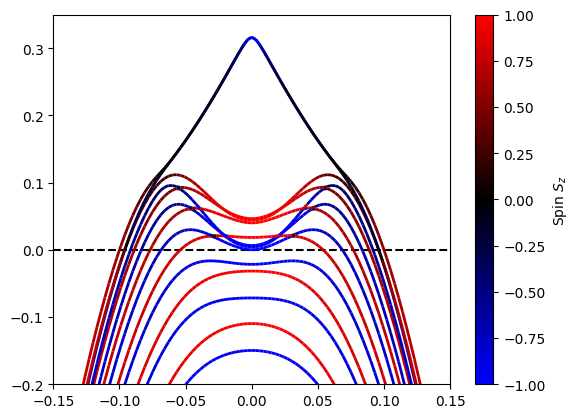

In [4]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap with wide black region
colors = [
    (0.0, (0, 0, 1)),   # blue at left
    (0.5, (0, 0, 0)),   # black starts early
    (0.5, (0, 0, 0)),   # black ends late
    (1.0, (1, 0, 0))    # red at right
]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("blue_wideblack_red", colors, N=256)

# figure
fig, ax = plt.subplots(1)
# horizontal line zero energy
ax.axhline(0, ls='--', lw=1.5, c='black')

# number of k values
k_dim = spinors.shape[0]; print(spinors.shape)
# normalize between -1 and 1
norm = Normalize(vmin=-1, vmax=1)

# Sz operator in orbital x spin basis
Sz = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))


n = 50
for idx in range(n):
    
    # eigenstate index
    iegv = 200 - int(n/2) + idx 

    # get spin z for colors
    spin_z = np.array([np.sum([np.vdot(s, Sz @ s).real for s in spinors[kdx,iegv]]) for kdx in range(k_dim)])
    #spin_z = np.zeros(k_dim)
    
    # define x and y arrays for plot
    x,y = momentum, egval[:,iegv]
    
    # create line segments between consecutive points
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # create LineCollection
    lc = LineCollection(segments, cmap=cmap, array=spin_z[:-1], lw=2, norm=norm)

    # plot line
    line = ax.add_collection(lc)

fig.colorbar(line, ax=ax, label="Spin $S_z$")

ax.set_xlim(-0.15, 0.15);
ax.set_ylim(-0.2, 0.35);

## **Induced Pairing**

#### **Surface States $d=100 \, \mathrm{Å}$**

In [2]:
# shape of the matrix 
n = 4

# space dimensions
K_surf = []; Z_surf = []
k_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("Pairing/pairing_surface.txt")

# store data in matrices
F_surface = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K_surf.append(float(row[0]))
    
        if idx == 0: Z_surf.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_surface[idx][jdx] = Change_Basis(matrix)

print(F_surface.shape)

(100, 100, 4, 4)


#### **Bulk States $d=100 \, \mathrm{Å}$**

In [3]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 100

# read file pairing
rows = np.loadtxt("Pairing/pairing_bulk-100.txt")

# store data in matrices
F_bulk_100 = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_bulk_100[idx][jdx] = Change_Basis(matrix)

print(F_bulk_100.shape)

(100, 100, 4, 4)


#### **Bulk States $d=150 \, \mathrm{Å}$**

In [5]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 200

# read file pairing
rows = np.loadtxt("Pairing/pairing_bulk-150.txt")

# store data in matrices
F_bulk_150 = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_bulk_150[idx][jdx] = Change_Basis(matrix)

print(F_bulk_150.shape)

(100, 200, 4, 4)


#### **Bulk States $d=200 \, \mathrm{Å}$**

In [6]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 200

# read file pairing
rows = np.loadtxt("Pairing/pairing_bulk-200.txt")

# store data in matrices
F_bulk_200 = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_bulk_200[idx][jdx] = Change_Basis(matrix)

print(F_bulk_200.shape)

(100, 200, 4, 4)


#### **Bulk States $d=250 \, \mathrm{Å}$**

In [7]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 200

# read file pairing
rows = np.loadtxt("Pairing/pairing_bulk-250.txt")

# store data in matrices
F_bulk_250 = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_bulk_250[idx][jdx] = Change_Basis(matrix)

print(F_bulk_250.shape)

(100, 200, 4, 4)


#### **Bulk States $d=300 \, \mathrm{Å}$**

In [8]:
# shape of the matrix 
n = 4

# space dimensions
K = []; Z = []
k_dim = 100; z_dim = 200

# read file pairing
rows = np.loadtxt("Pairing/pairing_bulk-300.txt")

# store data in matrices
F_bulk_300 = np.empty((k_dim, z_dim, 4, 4), dtype='complex')


# loop over momenta
for idx in range(k_dim):
    
    # loop over space
    for jdx in range(z_dim):

        # index for rows
        irow = z_dim * idx + jdx
                
        # read one row
        row = rows[irow]
    
        if jdx == 0: K.append(float(row[0]))
    
        if idx == 0: Z.append(float(row[1]))
    
        # real part
        real = row[2 : 2 + n*n].reshape((n, n))
        # imaginary part
        imag = row[2 + n*n :].reshape((n, n))
        # pairing matrix
        matrix = real + 1j * imag

        F_bulk_300[idx][jdx] = Change_Basis(matrix)

print(F_bulk_300.shape)

(100, 200, 4, 4)


#### <span style="color:green"> **Space Dependence** </span>

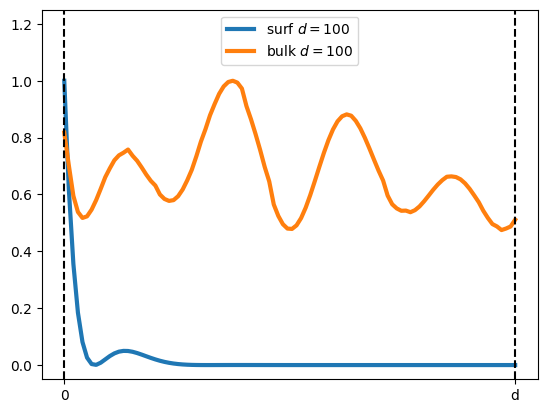

In [10]:
fig, ax = plt.subplots(1)

#labels= ['surf $d=100$', 'bulk $d=100$', 'bulk $d=150$', 'bulk $d=200$', 'bulk $d=250$', 'bulk $d=300$']
#pairing = [F_surface, F_bulk_100, F_bulk_150, F_bulk_200, F_bulk_250, F_bulk_300]


labels= ['surf $d=100$', 'bulk $d=100$']
pairing = [F_surface, F_bulk_100]


for F, lab, xlat in zip(pairing, labels, [100, 100]):

    # compute norm of pairing    
    f = np.linalg.norm(F, axis=(2, 3))

    # normlaize max = 1
    norm = np.max( np.sum(f, axis=0) )
    

    # plot pairing
    ax.plot(np.linspace(0,1, xlat), np.sum(f, axis=0)/norm, lw=3, label=lab)

# interfaces
ax.axvline(0, lw=1.5, ls='--', c='black')
ax.axvline(1, lw=1.5, ls='--', c='black')

ax.set_xticks([0, 1], ['0', 'd']);
ax.set_ylim(ax.get_ylim()[0], 1.25)
ax.legend();